In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy import io
import random
import numpy as np
import tensorflow as tf
import os
import sys
import pickle
import gzip
import random
import time
import shutil
import brain_python6 as bp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial import ConvexHull

n_times = 201
n_frequency = 79
n_outputs = 2

last_neurons = 40
n_neurons = [40,40,last_neurons]

want_accuracy = 1.0
last_accuracy = 0

max_load = 5
high_max_load = 10

load_number = ''

important_index = [105,125]
normal_range_index = [20,180]
window = 30
step = 1

data_base_path = "./brain_data8~50"
test_data_base_path = "./brain_data8~50_t"
ckpt_base_path = "./ckpt/"
high_weight_path_base = "./ckpt/high/"

eeg = bp.brain_python(n_times,n_frequency,window,n_outputs)
label_list,_,_ = eeg.label_info(data_base_path)
test_label_list,_,_ = eeg.label_info(test_data_base_path)
train_data,train_data_label,_ = eeg.preprocessing(data_base_path)
test_data,test_data_label,_ = eeg.preprocessing(test_data_base_path,equal_count_data=False)

test_data = test_data[:,100:130]
final_data, final_data_label = eeg.data_multiple(train_data,train_data_label,label_list,important_index,normal_range_index,step)


# final_data_reverse = np.flip(final_data,axis=1)

# final_data=np.concatenate((final_data,final_data_reverse),axis=0)
# final_data_label=np.concatenate((final_data_label,final_data_label),axis=0)

# test_data=np.flip(test_data,axis=1)

batch_size = 20

normal
normal


In [2]:
def intersection(linex1,liney1,linex2,liney2):
    f1 = (linex1[1]-linex1[0])*(liney2[0]-liney1[0])-(liney1[1]-liney1[0])*(linex2[0]-linex1[0])
    f2 = (linex1[1]-linex1[0])*(liney2[1]-liney1[0])-(liney1[1]-liney1[0])*(linex2[1]-linex1[0])
    f3 = (linex2[1]-linex2[0])*(liney1[0]-liney2[0])-(liney2[1]-liney2[0])*(linex1[0]-linex2[0])
    f4 = (linex2[1]-linex2[0])*(liney1[1]-liney2[0])-(liney2[1]-liney2[0])*(linex1[1]-linex2[0])
    
    if f1*f2<0 and f3*f4<0:
        return 1
    else :
        return 0
        
def intersection_dot(linex1,liney1,linex2,liney2):
        m1 = (liney1[1]-liney1[0])/(linex1[1]-linex1[0])
        m2 = (liney2[1]-liney2[0])/(linex2[1]-linex2[0])
        cx = (linex1[0]*m1-liney1[0]-linex2[0]*m2+liney2[0])/(m1-m2)
        cy = m1*(cx-linex1[0])+liney1[0]
        return np.array([[cx, cy]],float)
        
def intersection_inner(linex,liney,dot,max_dot):
        f1 = (linex[1]-linex[0])*(dot[1]-liney[0])-(liney[1]-liney[0])*(dot[0]-linex[0])
        f2 = (linex[1]-linex[0])*(dot[1]-liney[0])-(liney[1]-liney[0])*(max_dot-linex[0])
        f3 = (max_dot-dot[0])*(liney[0]-dot[1])-(dot[1]-dot[1])*(linex[0]-dot[0])
        f4 = (max_dot-dot[0])*(liney[1]-dot[1])-(dot[1]-dot[1])*(linex[1]-dot[0])

        if f1*f2<0 and f3*f4<0:
            return 1
        else :
            return 0

In [19]:
def pca_data(input_data):
    final_data = input_data
    # plus
    cut_times = 8
    stride = 2
    cluster_data = np.zeros([final_data.shape[0]*((final_data.shape[1]-cut_times+stride)//stride),cut_times,final_data.shape[2]])

    cluster_number = 0
    for input_data in final_data:
        for i in range(0,final_data.shape[1]-cut_times+stride,stride):
            cluster_data[cluster_number]=input_data[i:i+cut_times]
            cluster_number += 1

    action_cluster_data = cluster_data
    # action_cluster_data = cluster_data[:sum(train_data_label==[1,0])[0]*train_data.shape[1]//cut_times]


    scaler = StandardScaler()

    # action_cluster_data=np.transpose(action_cluster_data,(0,2,1))

    pca_1 = PCA(n_components=1)
    pca_2 = PCA(n_components=2)

    pc_data = np.zeros([action_cluster_data.shape[0],action_cluster_data.shape[1],1])
    for i in range(action_cluster_data.shape[0]):
        pc_data[i] = pca_1.fit_transform(action_cluster_data[i])
        
    pc_data = pc_data.reshape(pc_data.shape[0],pc_data.shape[1])
    pc_data = scaler.fit_transform(pc_data)

    pc = pca_2.fit_transform(pc_data)
    
    #normal outlier

    clf = LocalOutlierFactor(n_neighbors=int(pc.shape[0]*0.005),contamination='auto')
    outlier_index = clf.fit_predict(pc)
    pc = np.delete(pc,np.where(outlier_index==-1),axis=0)
    
    return pc

In [4]:
def IOU_score(pc1,pc2):
    pc1_hull = ConvexHull(pc1).simplices
    pc2_hull = ConvexHull(pc2).simplices

    IOU_dot = np.empty((0,2),float)
    for i in np.unique(pc2_hull):
        count=0
        for simplex1 in pc1_hull:
            count+=intersection_inner(pc1[simplex1,0],pc1[simplex1,1],pc2[i],9999)
        if count%2 == 1:
            IOU_dot = np.append(IOU_dot, pc2[i].reshape(-1,2), axis=0)

    for i in np.unique(pc1_hull):
        count=0
        for simplex2 in pc2_hull:
            count+=intersection_inner(pc2[simplex2,0],pc2[simplex2,1],pc1[i],9999)
        if count%2 == 1:
            IOU_dot = np.append(IOU_dot, pc1[i].reshape(-1,2), axis=0)

    for simplex1 in pc1_hull:

        for simplex2 in pc2_hull:

            if intersection(pc1[simplex1,0],pc1[simplex1,1],pc2[simplex2,0],pc2[simplex2,1]) == 1:
                intersection_point=intersection_dot(pc1[simplex1,0],pc1[simplex1,1],pc2[simplex2,0],pc2[simplex2,1])
                IOU_dot = np.append(IOU_dot,intersection_point,axis=0)

    for simplex1 in pc1_hull:
        plt.plot(pc1[simplex1,0],pc1[simplex1,1],'r--')

    for simplex2 in pc2_hull:
        plt.plot(pc2[simplex2,0],pc2[simplex2,1],'g--')

    for pointing in IOU_dot:
        plt.plot(pointing[0],pointing[1],'ro')
        
    plt.scatter(pc1[:,0],pc1[:,1],marker=".",s=50)
    plt.scatter(pc2[:,0],pc2[:,1],marker="+",s=10)

    plt.show()

    IOU_score=ConvexHull(IOU_dot).volume/(ConvexHull(pc1).volume+ConvexHull(pc2).volume-ConvexHull(IOU_dot).volume)
    
    return IOU_score

In [5]:
# Generator
Generator = tf.keras.Sequential()
Generator.add(layers.Dense(7*19*256,use_bias=False,input_shape=(100,)))
Generator.add(layers.BatchNormalization())
Generator.add(layers.LeakyReLU())

Generator.add(layers.Reshape((7,19,256)))

Generator.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
Generator.add(layers.BatchNormalization())
Generator.add(layers.LeakyReLU())

Generator.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
Generator.add(layers.BatchNormalization())
Generator.add(layers.LeakyReLU())

Generator.add(layers.Conv2DTranspose(1,(4,5),strides=(2,2),padding='valid',use_bias=False,activation='tanh'))
# Generator.add(layers.Reshape((30,79)))

In [6]:
Discriminator = tf.keras.Sequential()
Discriminator.add(layers.Conv2D(64, (5,5),strides=(2,2),padding='same',input_shape=[30,79,1]))

Discriminator.add(layers.LeakyReLU())
Discriminator.add(layers.Dropout(0.3))

Discriminator.add(layers.Conv2D(128, (5,5),strides = (2,2),padding = 'same'))
Discriminator.add(layers.LeakyReLU())
Discriminator.add(layers.Dropout(0.3))

Discriminator.add(layers.Flatten())
Discriminator.add(layers.Dense(1))

In [7]:
# define Optimizer
Doptimizer = tf.keras.optimizers.Adam(0.0001)
Goptimizer = tf.keras.optimizers.Adam(0.0001)

In [8]:
def get_noise(batch_size,n_noise):
    return tf.random.normal([batch_size,n_noise])

def train_step(inputs):

    with tf.GradientTape() as t1, tf.GradientTape() as t2:
        # 잡음으로부터 이미지 생성
        G = Generator(get_noise(inputs.shape[0],100))
#         G = Generator(noise)
        # 판별자 입력
        Z = Discriminator(G)
        R = Discriminator(inputs)   
        # 손실 함수 연산
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        loss_D = cross_entropy(tf.ones_like(R),R)+cross_entropy(tf.zeros_like(Z),Z)
        loss_G = cross_entropy(tf.ones_like(Z),Z)

    # 판별자 업데이트      
    Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
    Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))
    # 생성자 업데이트
    Ggradients = t2.gradient(loss_G,Generator.trainable_variables)
    Goptimizer.apply_gradients(zip(Ggradients, Generator.trainable_variables)) 
    return loss_D, loss_G,G,Z,R

In [9]:
# min_max_scaler = MinMaxScaler()
# final_data_limit = np.zeros_like(final_data)
# test_data_limit = np.zeros_like(test_data)

# for i in range(final_data.shape[0]):
#     final_data_limit[i]=min_max_scaler.fit_transform(final_data[i])
    
# final_data_limit-=0.5
# final_data_limit*=2

In [10]:
# limit_part = 1500
# final_data_limit = np.zeros_like(final_data)
# test_data_limit = np.zeros_like(test_data)

# for i in range(final_data.shape[0]):
#     for j in np.arange(0,1,1/limit_part):
#         final_data_limit[i]+=(final_data[i]>=(final_data[i].max()*j))
        
# final_data_limit = final_data_limit/1500-0.5

# # for i in range(test_data.shape[0]):
# #     for j in np.arange(0,1,1/limit_part):
# #         test_data_limit[i]+=(test_data[i]>=(test_data[i].max()*j))

In [11]:
final_data_limit=final_data

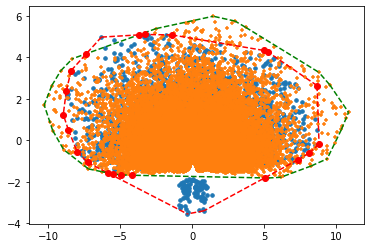

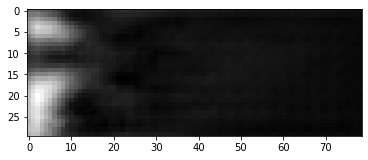

l_D: tf.Tensor(1.4384217, shape=(), dtype=float32)
l_G: tf.Tensor(0.6738304, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03924152], shape=(1,), dtype=float32)
IOU_score: 0.7581730475091535


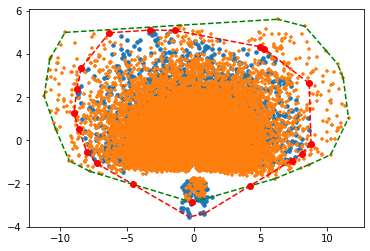

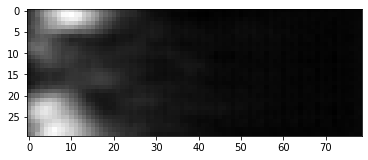

l_D: tf.Tensor(1.3566216, shape=(), dtype=float32)
l_G: tf.Tensor(0.7133802, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.0383021], shape=(1,), dtype=float32)
IOU_score: 0.7092600335342696


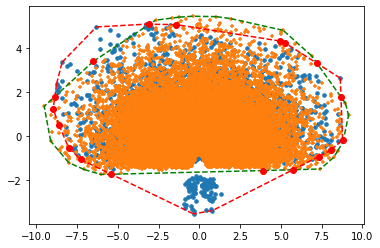

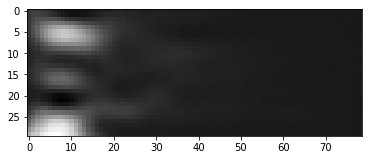

l_D: tf.Tensor(1.3663464, shape=(), dtype=float32)
l_G: tf.Tensor(0.6630866, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06360057], shape=(1,), dtype=float32)
IOU_score: 0.7840260790164381


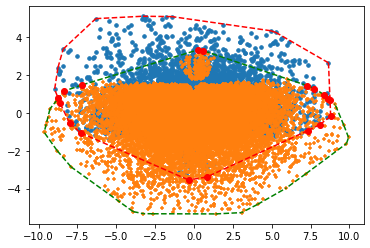

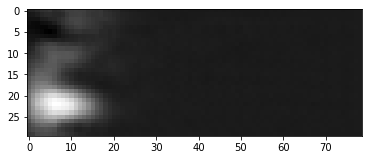

l_D: tf.Tensor(1.4239063, shape=(), dtype=float32)
l_G: tf.Tensor(0.6734464, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.04066842], shape=(1,), dtype=float32)
IOU_score: 0.46468722567595205


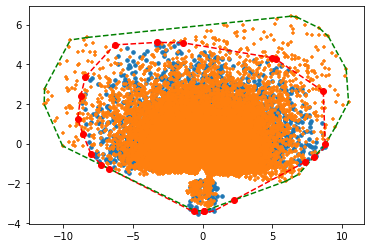

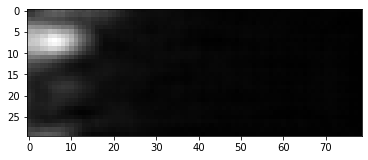

l_D: tf.Tensor(1.4377892, shape=(), dtype=float32)
l_G: tf.Tensor(0.73860615, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.08762734], shape=(1,), dtype=float32)
IOU_score: 0.7149087973719839


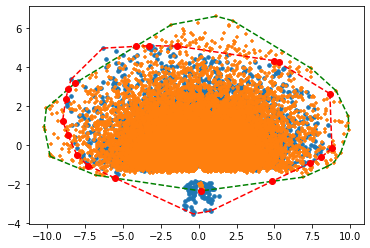

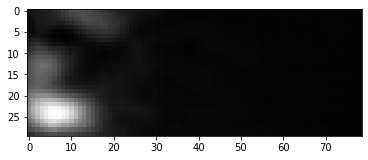

l_D: tf.Tensor(1.3708456, shape=(), dtype=float32)
l_G: tf.Tensor(0.66127485, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06628899], shape=(1,), dtype=float32)
IOU_score: 0.7614519139251827


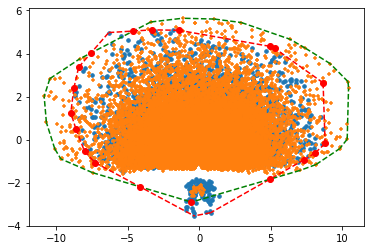

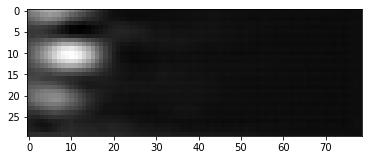

l_D: tf.Tensor(1.3911316, shape=(), dtype=float32)
l_G: tf.Tensor(0.6583966, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.07292219], shape=(1,), dtype=float32)
IOU_score: 0.7785645107915514


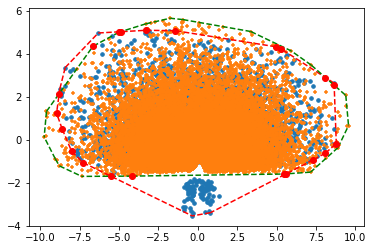

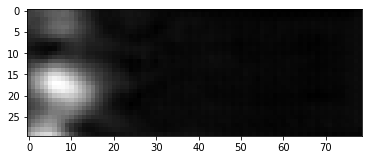

l_D: tf.Tensor(1.4352205, shape=(), dtype=float32)
l_G: tf.Tensor(0.68713546, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.0148977], shape=(1,), dtype=float32)
IOU_score: 0.8035684513506757


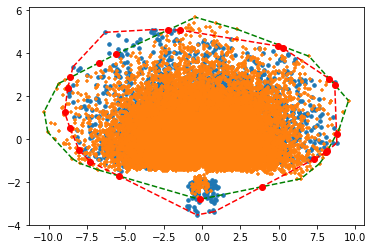

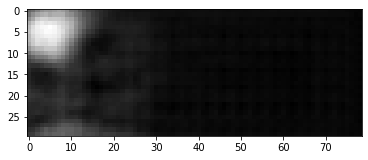

l_D: tf.Tensor(1.3200402, shape=(), dtype=float32)
l_G: tf.Tensor(0.6870532, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01254648], shape=(1,), dtype=float32)
IOU_score: 0.844302241919766


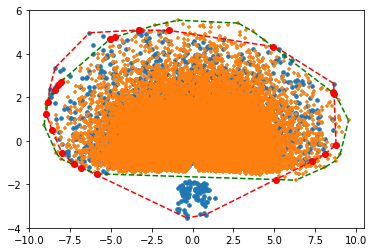

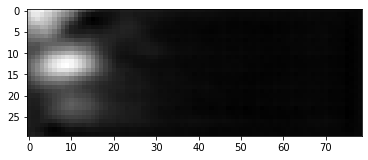

l_D: tf.Tensor(1.3504522, shape=(), dtype=float32)
l_G: tf.Tensor(0.7255064, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.06269813], shape=(1,), dtype=float32)
IOU_score: 0.8044032650335086


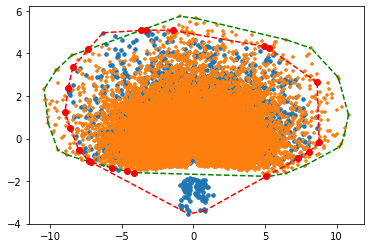

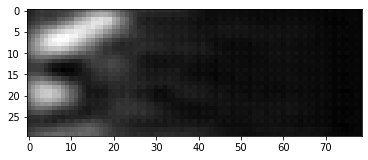

l_D: tf.Tensor(1.408716, shape=(), dtype=float32)
l_G: tf.Tensor(0.6657753, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.05638956], shape=(1,), dtype=float32)
IOU_score: 0.7374903329109601


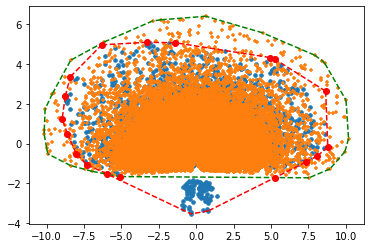

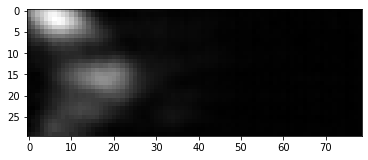

l_D: tf.Tensor(1.3800035, shape=(), dtype=float32)
l_G: tf.Tensor(0.72557044, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.06200984], shape=(1,), dtype=float32)
IOU_score: 0.7065557452545993


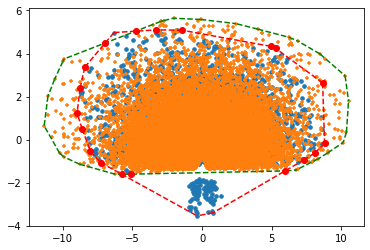

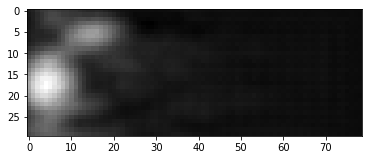

l_D: tf.Tensor(1.4021312, shape=(), dtype=float32)
l_G: tf.Tensor(0.66856986, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.05057829], shape=(1,), dtype=float32)
IOU_score: 0.7089947369985873


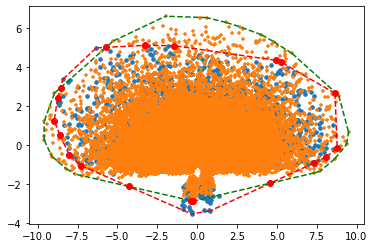

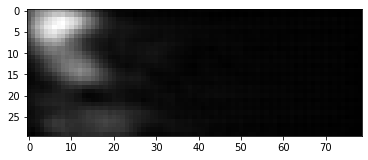

l_D: tf.Tensor(1.3667736, shape=(), dtype=float32)
l_G: tf.Tensor(0.6597711, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.07087164], shape=(1,), dtype=float32)
IOU_score: 0.8043510989200644


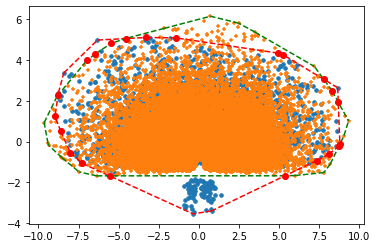

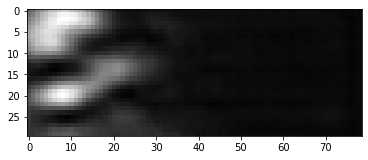

l_D: tf.Tensor(1.394151, shape=(), dtype=float32)
l_G: tf.Tensor(0.71480083, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.04194124], shape=(1,), dtype=float32)
IOU_score: 0.7944999759452803


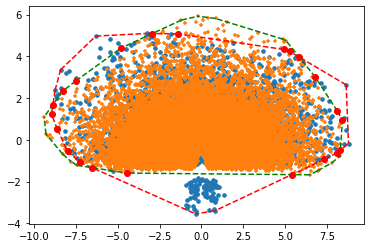

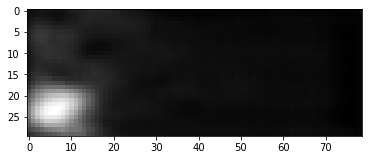

l_D: tf.Tensor(1.3584809, shape=(), dtype=float32)
l_G: tf.Tensor(0.6610987, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06698044], shape=(1,), dtype=float32)
IOU_score: 0.7694596412211949


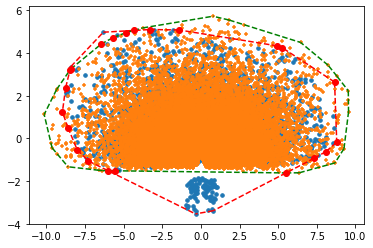

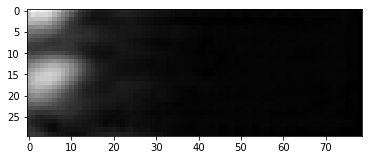

l_D: tf.Tensor(1.4237776, shape=(), dtype=float32)
l_G: tf.Tensor(0.69264853, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00337916], shape=(1,), dtype=float32)
IOU_score: 0.7721927054362743


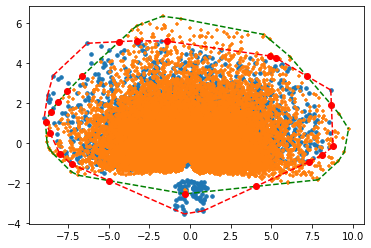

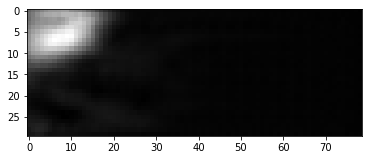

l_D: tf.Tensor(1.3757435, shape=(), dtype=float32)
l_G: tf.Tensor(0.68000305, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02737251], shape=(1,), dtype=float32)
IOU_score: 0.7894525747481236


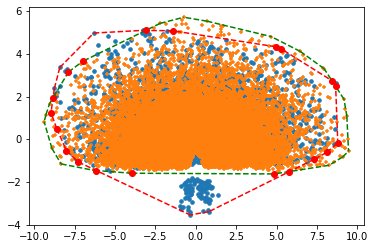

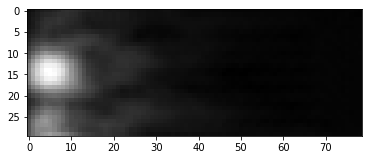

l_D: tf.Tensor(1.378335, shape=(), dtype=float32)
l_G: tf.Tensor(0.69539005, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.00255988], shape=(1,), dtype=float32)
IOU_score: 0.7896697855566667


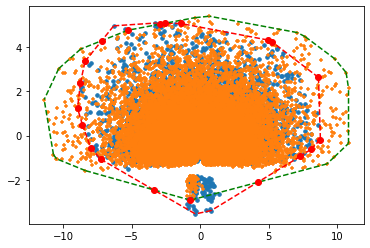

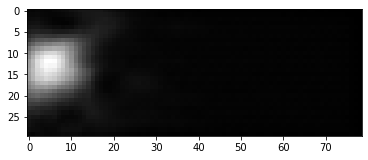

l_D: tf.Tensor(1.41698, shape=(), dtype=float32)
l_G: tf.Tensor(0.6667966, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.05411347], shape=(1,), dtype=float32)
IOU_score: 0.7476917446753459


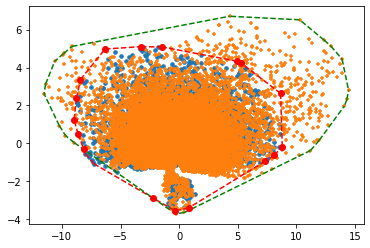

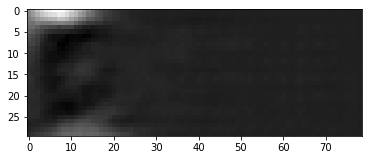

l_D: tf.Tensor(1.4089615, shape=(), dtype=float32)
l_G: tf.Tensor(0.67468274, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03755542], shape=(1,), dtype=float32)
IOU_score: 0.6008148112031966


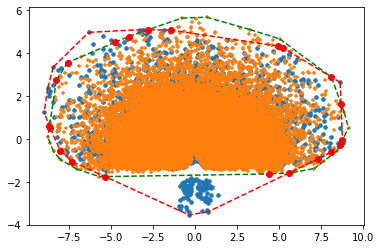

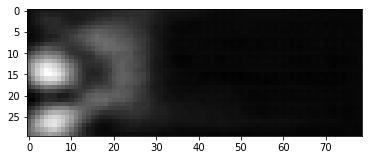

l_D: tf.Tensor(1.4279526, shape=(), dtype=float32)
l_G: tf.Tensor(0.64435446, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.10134008], shape=(1,), dtype=float32)
IOU_score: 0.8183404991181066


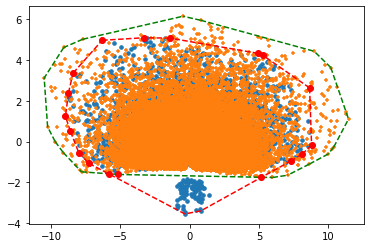

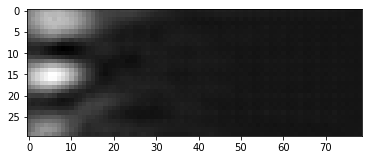

l_D: tf.Tensor(1.4024622, shape=(), dtype=float32)
l_G: tf.Tensor(0.69054383, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00743947], shape=(1,), dtype=float32)
IOU_score: 0.6822785881901396


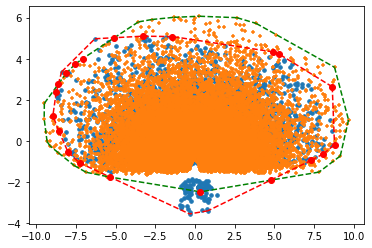

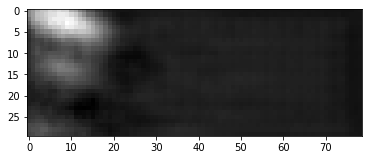

l_D: tf.Tensor(1.4805871, shape=(), dtype=float32)
l_G: tf.Tensor(0.6744257, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03861038], shape=(1,), dtype=float32)
IOU_score: 0.7911547656527524


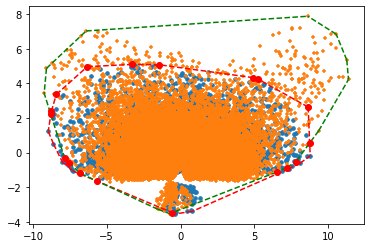

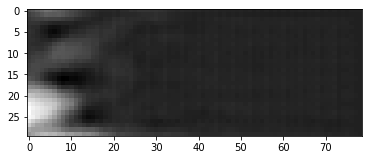

l_D: tf.Tensor(1.4239675, shape=(), dtype=float32)
l_G: tf.Tensor(0.66998804, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.04748893], shape=(1,), dtype=float32)
IOU_score: 0.6212409904935947


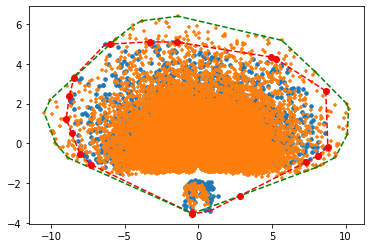

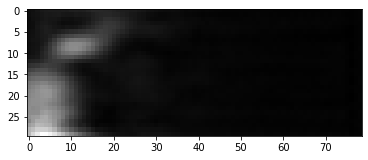

l_D: tf.Tensor(1.4139876, shape=(), dtype=float32)
l_G: tf.Tensor(0.7088829, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.03021218], shape=(1,), dtype=float32)
IOU_score: 0.8092356459195675


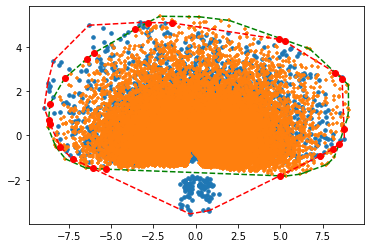

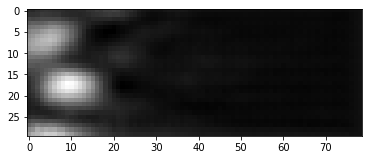

l_D: tf.Tensor(1.4076635, shape=(), dtype=float32)
l_G: tf.Tensor(0.6872585, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01711495], shape=(1,), dtype=float32)
IOU_score: 0.8089175865740486


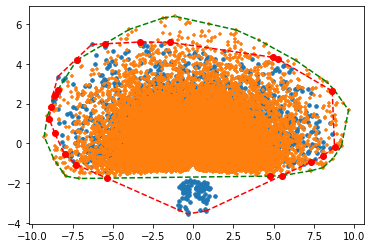

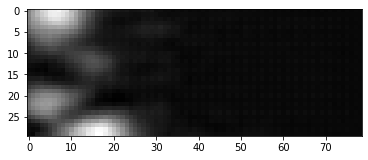

l_D: tf.Tensor(1.3717647, shape=(), dtype=float32)
l_G: tf.Tensor(0.70884264, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.02985638], shape=(1,), dtype=float32)
IOU_score: 0.7780515895180924


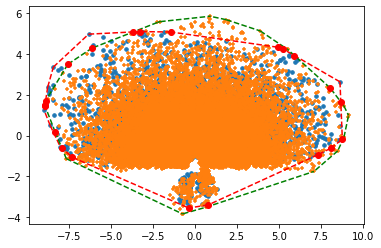

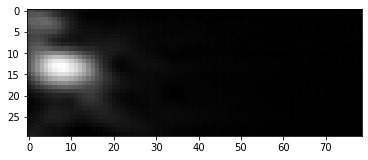

l_D: tf.Tensor(1.3559256, shape=(), dtype=float32)
l_G: tf.Tensor(0.6875289, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01211847], shape=(1,), dtype=float32)
IOU_score: 0.870451858371294


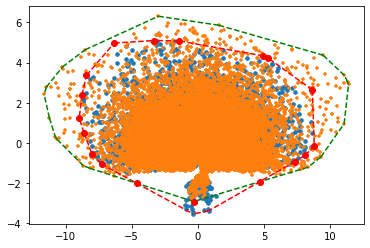

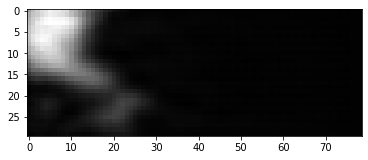

l_D: tf.Tensor(1.3548032, shape=(), dtype=float32)
l_G: tf.Tensor(0.69757986, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.00759954], shape=(1,), dtype=float32)
IOU_score: 0.7066066948677647


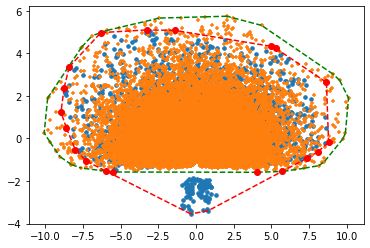

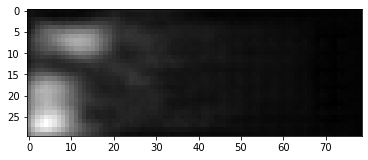

l_D: tf.Tensor(1.4032025, shape=(), dtype=float32)
l_G: tf.Tensor(0.6764348, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03614104], shape=(1,), dtype=float32)
IOU_score: 0.757876635402926


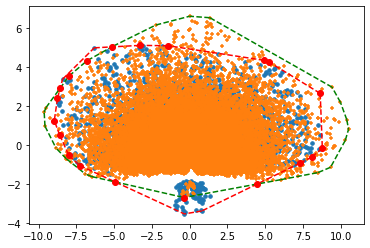

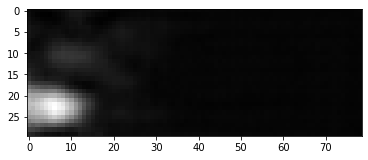

l_D: tf.Tensor(1.3972508, shape=(), dtype=float32)
l_G: tf.Tensor(0.70252097, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.01845336], shape=(1,), dtype=float32)
IOU_score: 0.7881968474279908


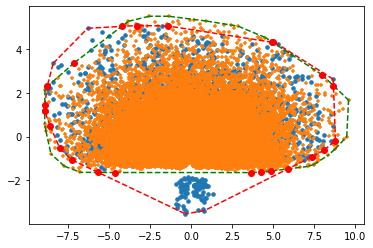

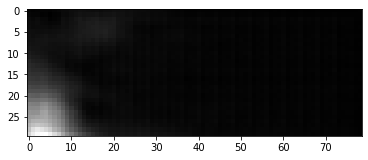

l_D: tf.Tensor(1.3684647, shape=(), dtype=float32)
l_G: tf.Tensor(0.67673326, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03442864], shape=(1,), dtype=float32)
IOU_score: 0.810259769123845


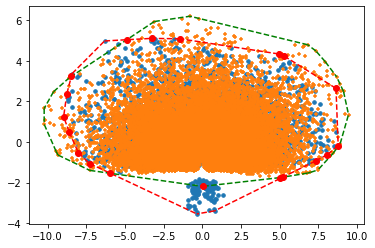

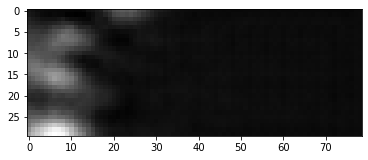

l_D: tf.Tensor(1.4112916, shape=(), dtype=float32)
l_G: tf.Tensor(0.68756056, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01155349], shape=(1,), dtype=float32)
IOU_score: 0.7770945458561348


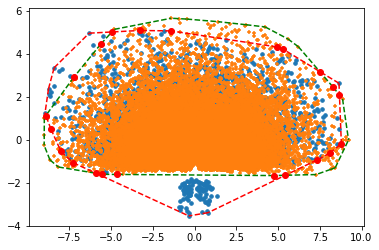

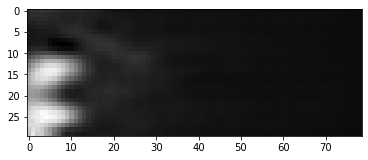

l_D: tf.Tensor(1.3471415, shape=(), dtype=float32)
l_G: tf.Tensor(0.687462, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01442095], shape=(1,), dtype=float32)
IOU_score: 0.7809466871816751


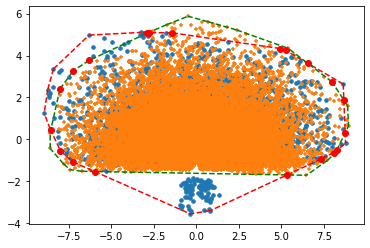

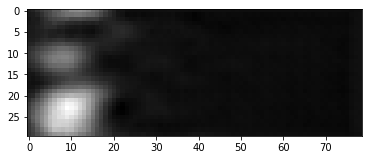

l_D: tf.Tensor(1.4224577, shape=(), dtype=float32)
l_G: tf.Tensor(0.76496834, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.13422473], shape=(1,), dtype=float32)
IOU_score: 0.7982520488750393


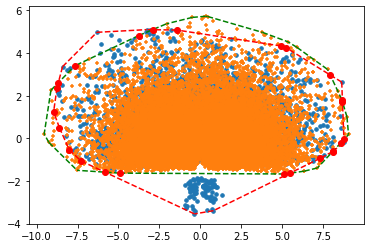

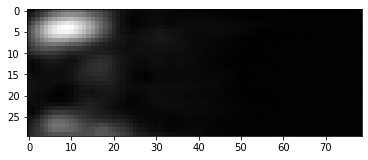

l_D: tf.Tensor(1.3348813, shape=(), dtype=float32)
l_G: tf.Tensor(0.7283642, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.06450282], shape=(1,), dtype=float32)
IOU_score: 0.8047578540184154


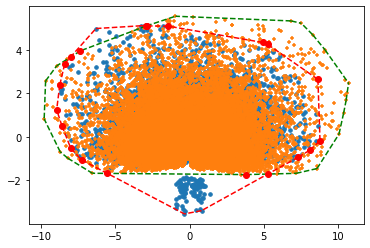

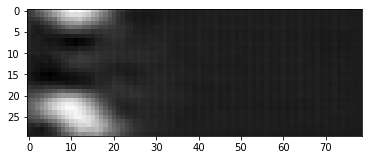

l_D: tf.Tensor(1.4040179, shape=(), dtype=float32)
l_G: tf.Tensor(0.67505544, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03768333], shape=(1,), dtype=float32)
IOU_score: 0.7312498052936054


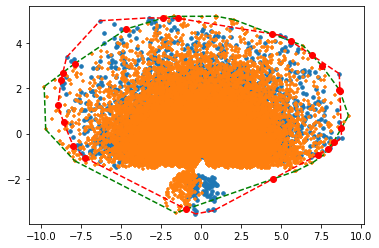

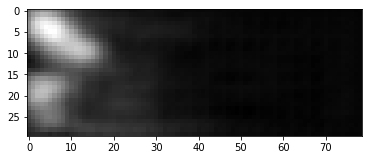

l_D: tf.Tensor(1.4179649, shape=(), dtype=float32)
l_G: tf.Tensor(0.6775397, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.0331029], shape=(1,), dtype=float32)
IOU_score: 0.8840459098194565


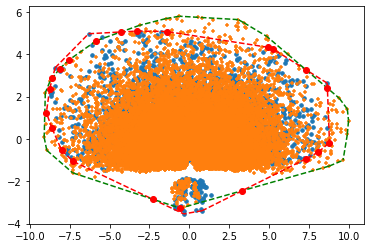

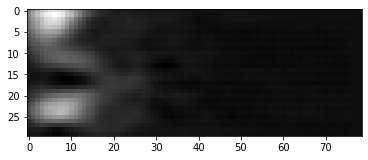

l_D: tf.Tensor(1.3640274, shape=(), dtype=float32)
l_G: tf.Tensor(0.73961866, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.08715986], shape=(1,), dtype=float32)
IOU_score: 0.85429633096334


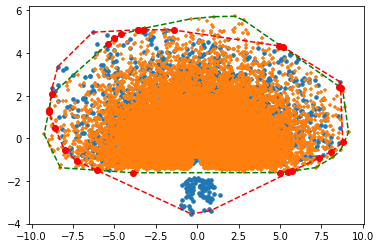

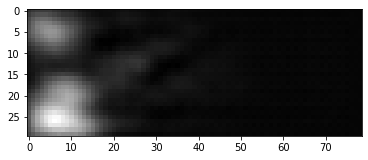

l_D: tf.Tensor(1.3548512, shape=(), dtype=float32)
l_G: tf.Tensor(0.73142177, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.07390396], shape=(1,), dtype=float32)
IOU_score: 0.7999404091664972


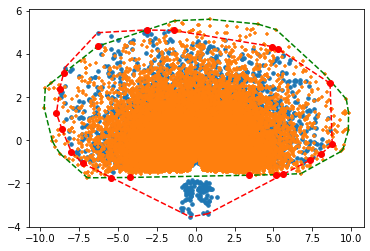

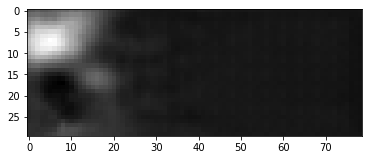

l_D: tf.Tensor(1.4254534, shape=(), dtype=float32)
l_G: tf.Tensor(0.71070224, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.03412689], shape=(1,), dtype=float32)
IOU_score: 0.7808270433122044


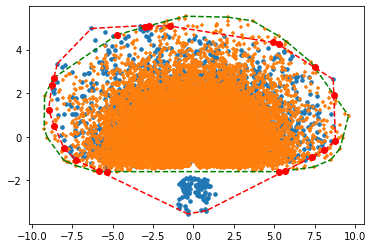

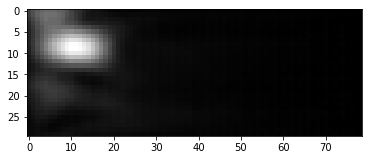

l_D: tf.Tensor(1.3916047, shape=(), dtype=float32)
l_G: tf.Tensor(0.6806389, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02820289], shape=(1,), dtype=float32)
IOU_score: 0.795299091478133


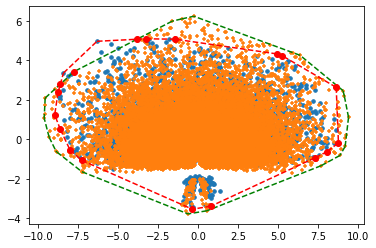

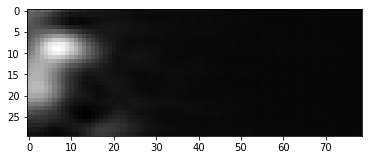

l_D: tf.Tensor(1.3832183, shape=(), dtype=float32)
l_G: tf.Tensor(0.64025235, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.11316206], shape=(1,), dtype=float32)
IOU_score: 0.8348068559858708


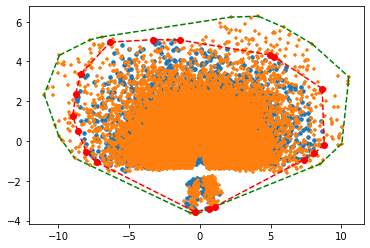

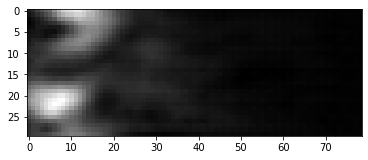

l_D: tf.Tensor(1.372452, shape=(), dtype=float32)
l_G: tf.Tensor(0.6616351, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06769327], shape=(1,), dtype=float32)
IOU_score: 0.7333501868026011


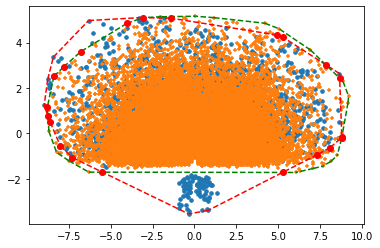

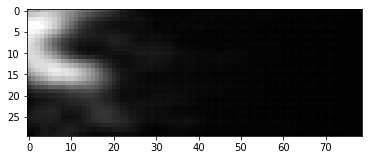

l_D: tf.Tensor(1.3469024, shape=(), dtype=float32)
l_G: tf.Tensor(0.6872681, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01206378], shape=(1,), dtype=float32)
IOU_score: 0.8266330410672172


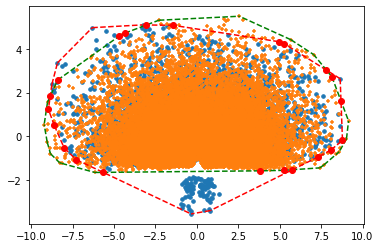

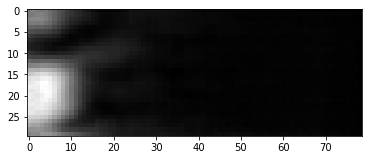

l_D: tf.Tensor(1.3688815, shape=(), dtype=float32)
l_G: tf.Tensor(0.6749358, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03726574], shape=(1,), dtype=float32)
IOU_score: 0.795734785118288


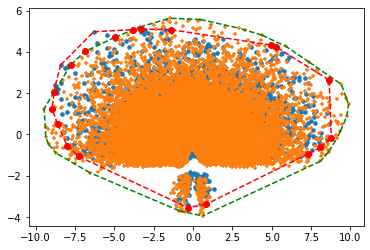

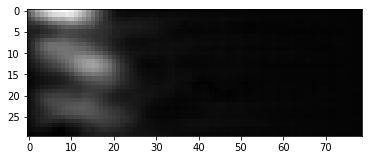

l_D: tf.Tensor(1.3594664, shape=(), dtype=float32)
l_G: tf.Tensor(0.6839746, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.018837], shape=(1,), dtype=float32)
IOU_score: 0.841176776148281


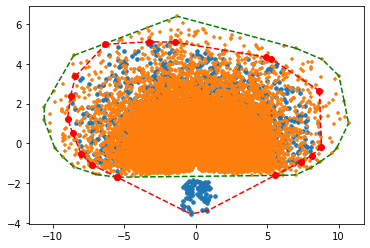

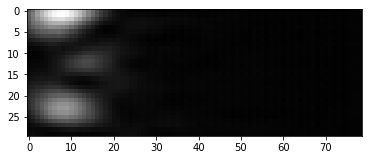

l_D: tf.Tensor(1.4040219, shape=(), dtype=float32)
l_G: tf.Tensor(0.6775182, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03260756], shape=(1,), dtype=float32)
IOU_score: 0.7021984287476718


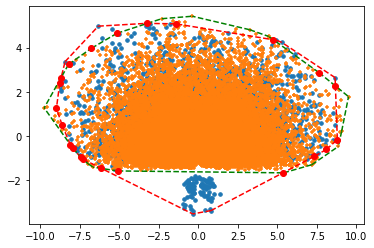

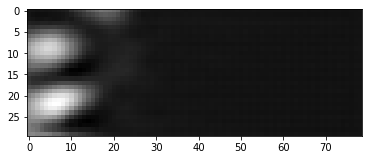

l_D: tf.Tensor(1.3562831, shape=(), dtype=float32)
l_G: tf.Tensor(0.70688975, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.02679596], shape=(1,), dtype=float32)
IOU_score: 0.8325011086354296


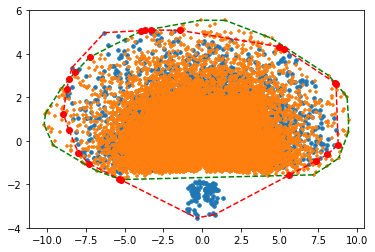

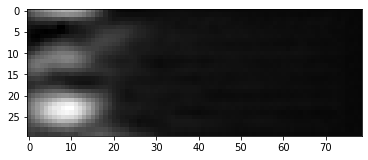

l_D: tf.Tensor(1.3671271, shape=(), dtype=float32)
l_G: tf.Tensor(0.6901165, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00758659], shape=(1,), dtype=float32)
IOU_score: 0.8070805299544208


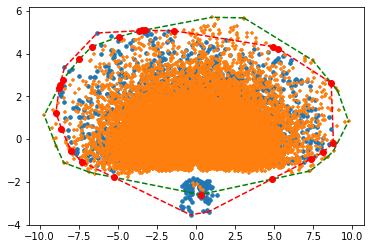

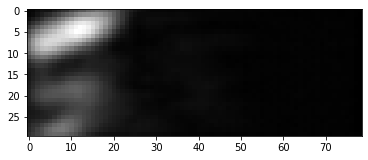

l_D: tf.Tensor(1.364739, shape=(), dtype=float32)
l_G: tf.Tensor(0.69729465, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.00625616], shape=(1,), dtype=float32)
IOU_score: 0.8416093020167449


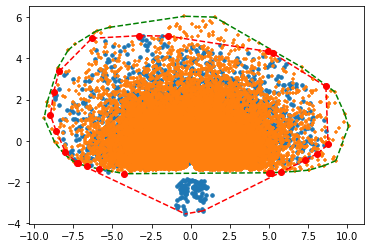

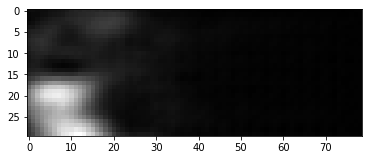

l_D: tf.Tensor(1.3804305, shape=(), dtype=float32)
l_G: tf.Tensor(0.6637681, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06085112], shape=(1,), dtype=float32)
IOU_score: 0.7800750050497308


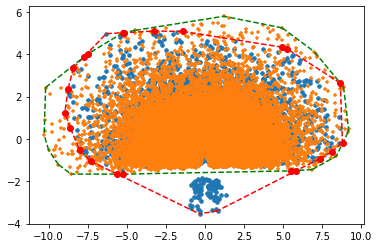

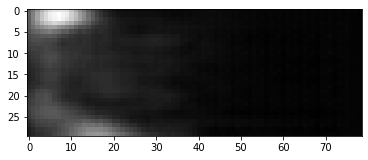

l_D: tf.Tensor(1.3812187, shape=(), dtype=float32)
l_G: tf.Tensor(0.6933303, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00019861], shape=(1,), dtype=float32)
IOU_score: 0.7679412017468746


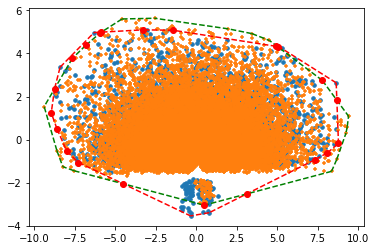

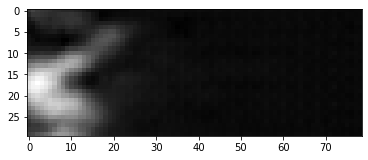

l_D: tf.Tensor(1.3782213, shape=(), dtype=float32)
l_G: tf.Tensor(0.69288015, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00093546], shape=(1,), dtype=float32)
IOU_score: 0.8802650012784634


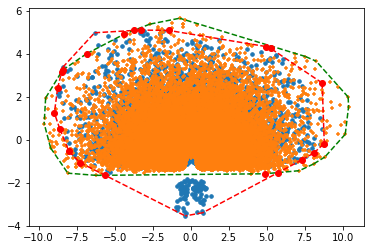

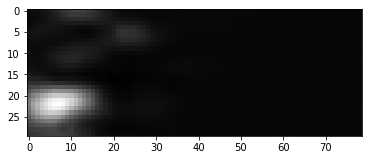

l_D: tf.Tensor(1.3707657, shape=(), dtype=float32)
l_G: tf.Tensor(0.70310885, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.01895471], shape=(1,), dtype=float32)
IOU_score: 0.7794196845737923


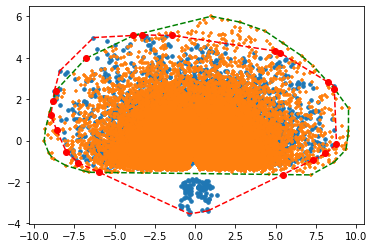

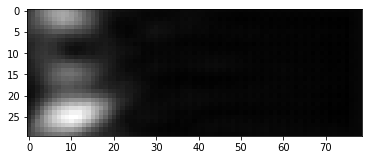

l_D: tf.Tensor(1.3930342, shape=(), dtype=float32)
l_G: tf.Tensor(0.6650002, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06308229], shape=(1,), dtype=float32)
IOU_score: 0.7745768705151452


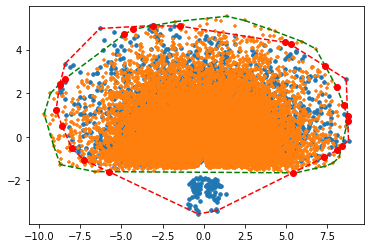

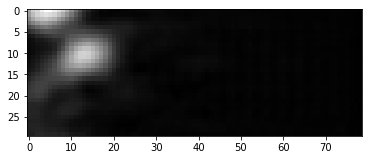

l_D: tf.Tensor(1.3734019, shape=(), dtype=float32)
l_G: tf.Tensor(0.6712478, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.04597571], shape=(1,), dtype=float32)
IOU_score: 0.796035631348357


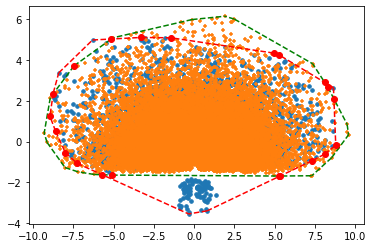

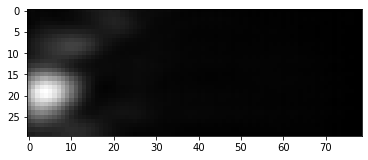

l_D: tf.Tensor(1.4011784, shape=(), dtype=float32)
l_G: tf.Tensor(0.6596266, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.07023651], shape=(1,), dtype=float32)
IOU_score: 0.7867095988961492


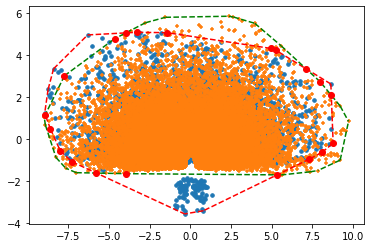

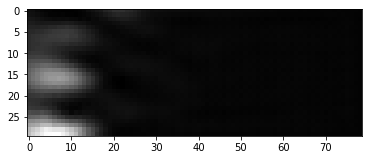

l_D: tf.Tensor(1.3883977, shape=(), dtype=float32)
l_G: tf.Tensor(0.71751285, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.04719795], shape=(1,), dtype=float32)
IOU_score: 0.7744174531028772


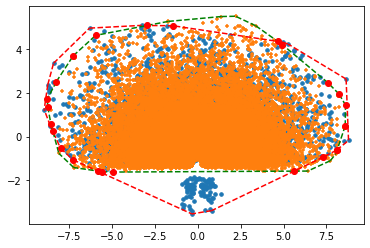

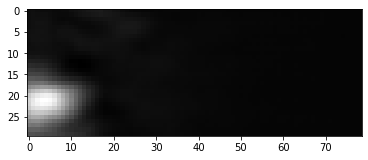

l_D: tf.Tensor(1.3622617, shape=(), dtype=float32)
l_G: tf.Tensor(0.67981625, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02937628], shape=(1,), dtype=float32)
IOU_score: 0.81746335663132


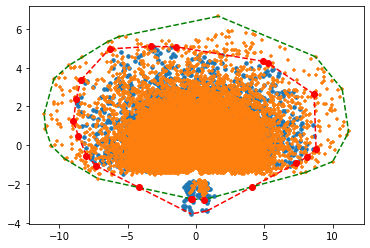

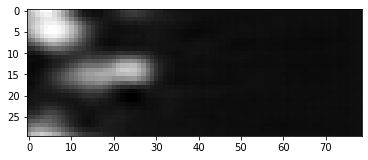

l_D: tf.Tensor(1.3803122, shape=(), dtype=float32)
l_G: tf.Tensor(0.72920144, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.06463286], shape=(1,), dtype=float32)
IOU_score: 0.6927059525401075


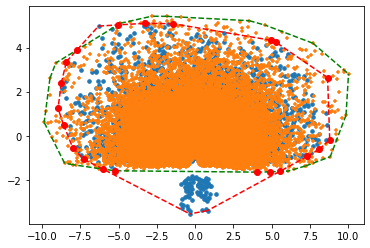

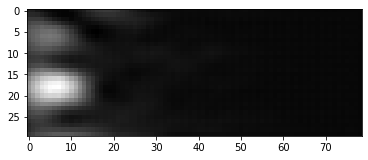

l_D: tf.Tensor(1.3962935, shape=(), dtype=float32)
l_G: tf.Tensor(0.6509201, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.08728386], shape=(1,), dtype=float32)
IOU_score: 0.7722307029847759


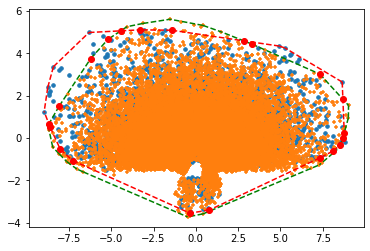

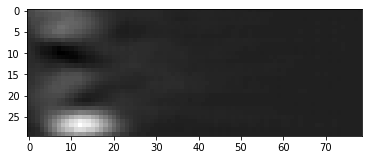

l_D: tf.Tensor(1.3947488, shape=(), dtype=float32)
l_G: tf.Tensor(0.6798156, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02723684], shape=(1,), dtype=float32)
IOU_score: 0.877959275571038


In [20]:
# 배치 사이즈
total_batch = int(final_data_limit.shape[0]/batch_size) 
np_load_count = 0
number_of_load = 200
want_data = 2000
stop_per = 0
# noise = get_noise(batch_size,100)
        
for epoch in tf.range(20000):
    for i in tf.range(total_batch):
        batch_input = final_data_limit[i*batch_size:(i+1)*batch_size]
        batch_input = np.reshape(batch_input,[-1,30,79,1])

        l_D,l_G,G_v,Z_v,R_v=train_step(batch_input)
        
        
# 생성된 이미지
    if epoch%50==0:
        G = Generator(get_noise(1,100))
        
        pc1=pca_data(final_data_limit)
        pc2=pca_data(np.reshape(Generator(get_noise(2000,100)),(-1,30,79)))
        IOU = IOU_score(pc1,pc2)
        if IOU>0.85:
            for np_load in range(number_of_load):
                G = Generator(get_noise(5,100))
                file_name = './gan_normal_file4/saved_'+str(np_load+np_load_count)
                np.save(file_name,G)
                stop_per = np_load+np_load_count
            np_load_count += number_of_load

        plt.imshow(np.reshape(G[0],(30,79)),interpolation="nearest",cmap='gray')
        plt.pause(0.001)
        print("l_D:",str(l_D))
        print("l_G:",str(l_G))
        print("Z_avr:",str(sum(Z_v)/Z_v.shape[0]))
        print("IOU_score:",str(IOU))
        plt.show()
        
    if stop_per >= want_data-1:
        break
    if np_load_count >= 999 :
        break

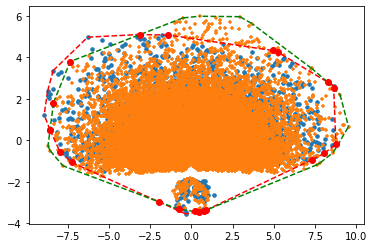

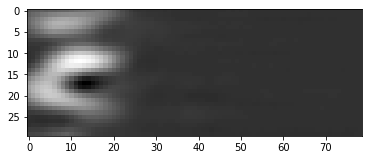

l_D: tf.Tensor(1.4205166, shape=(), dtype=float32)
l_G: tf.Tensor(0.7059084, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.02040987], shape=(1,), dtype=float32)
IOU_score: 0.8663588632099545


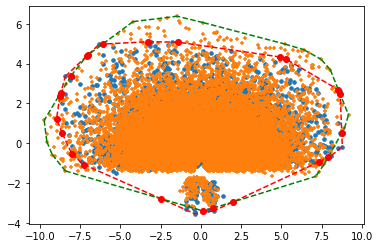

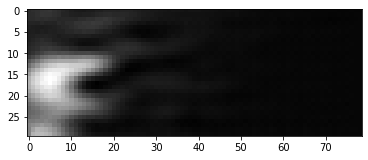

l_D: tf.Tensor(1.3957484, shape=(), dtype=float32)
l_G: tf.Tensor(0.6701044, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.05175894], shape=(1,), dtype=float32)
IOU_score: 0.8338522351086868


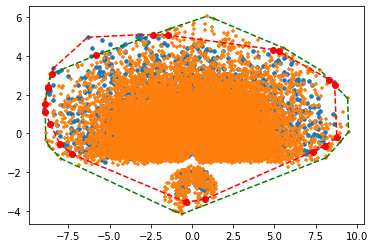

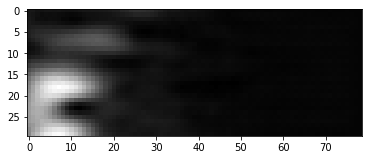

l_D: tf.Tensor(1.3869364, shape=(), dtype=float32)
l_G: tf.Tensor(0.72176194, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.05167031], shape=(1,), dtype=float32)
IOU_score: 0.8364105075467225


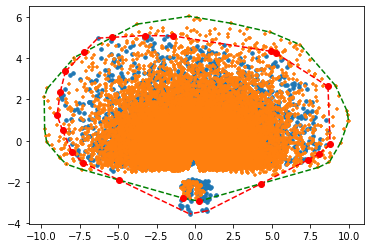

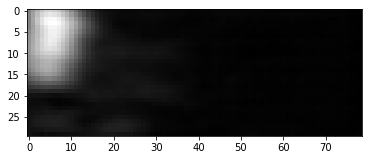

l_D: tf.Tensor(1.4149024, shape=(), dtype=float32)
l_G: tf.Tensor(0.67125094, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.04585772], shape=(1,), dtype=float32)
IOU_score: 0.8121787172119115


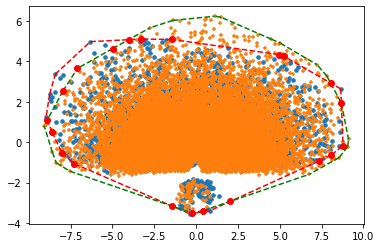

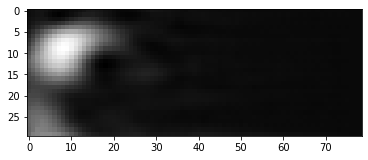

l_D: tf.Tensor(1.3862365, shape=(), dtype=float32)
l_G: tf.Tensor(0.68083704, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02604454], shape=(1,), dtype=float32)
IOU_score: 0.8518763626706198


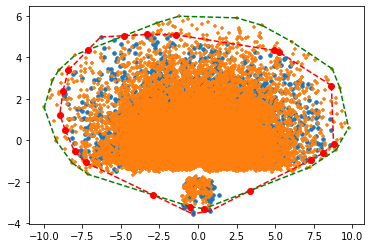

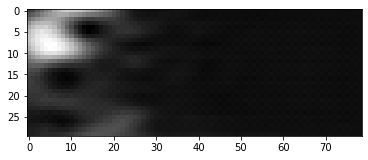

l_D: tf.Tensor(1.4269253, shape=(), dtype=float32)
l_G: tf.Tensor(0.65940094, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.07056914], shape=(1,), dtype=float32)
IOU_score: 0.8339016906593654


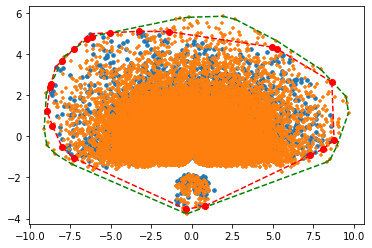

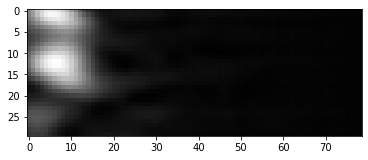

l_D: tf.Tensor(1.3873689, shape=(), dtype=float32)
l_G: tf.Tensor(0.67852366, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03028085], shape=(1,), dtype=float32)
IOU_score: 0.8705487669863359


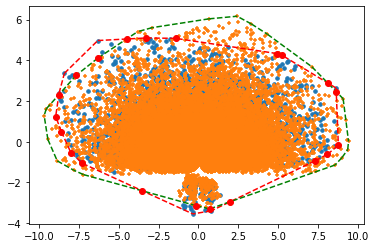

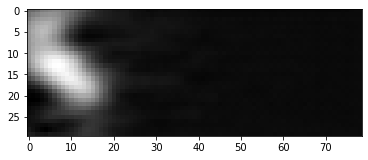

l_D: tf.Tensor(1.3643678, shape=(), dtype=float32)
l_G: tf.Tensor(0.6754769, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03668544], shape=(1,), dtype=float32)
IOU_score: 0.8352465936334538


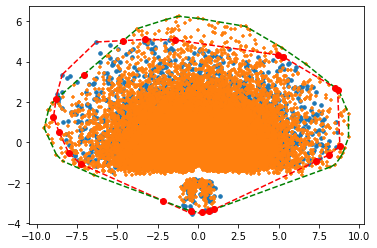

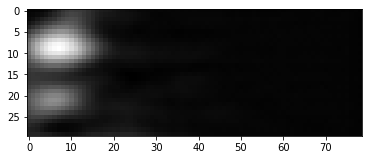

l_D: tf.Tensor(1.3648617, shape=(), dtype=float32)
l_G: tf.Tensor(0.6827618, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02642601], shape=(1,), dtype=float32)
IOU_score: 0.8432682338866547


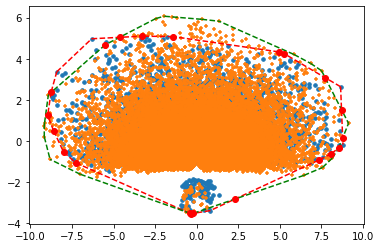

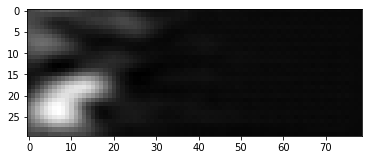

l_D: tf.Tensor(1.3715562, shape=(), dtype=float32)
l_G: tf.Tensor(0.66172993, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06657596], shape=(1,), dtype=float32)
IOU_score: 0.8701959122040056


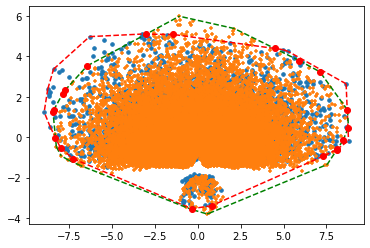

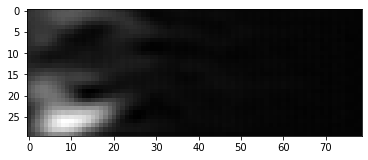

l_D: tf.Tensor(1.379836, shape=(), dtype=float32)
l_G: tf.Tensor(0.6786518, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03041222], shape=(1,), dtype=float32)
IOU_score: 0.8615907724139694


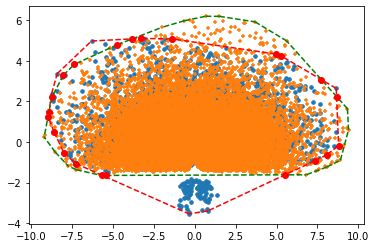

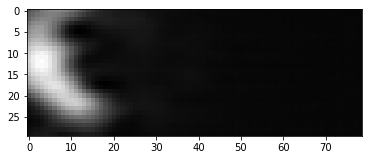

l_D: tf.Tensor(1.3999256, shape=(), dtype=float32)
l_G: tf.Tensor(0.6517978, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.08529346], shape=(1,), dtype=float32)
IOU_score: 0.777983255020719


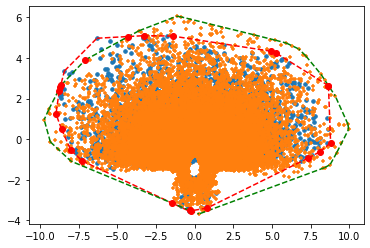

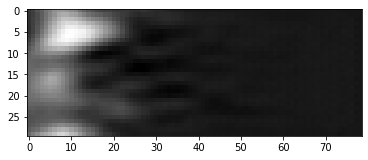

l_D: tf.Tensor(1.3485367, shape=(), dtype=float32)
l_G: tf.Tensor(0.72987765, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.06162144], shape=(1,), dtype=float32)
IOU_score: 0.8404918766279085


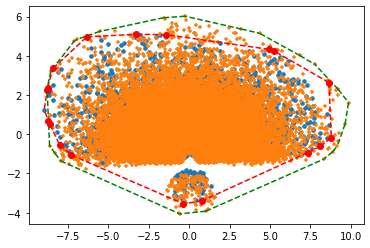

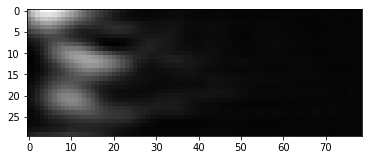

l_D: tf.Tensor(1.4022815, shape=(), dtype=float32)
l_G: tf.Tensor(0.7079158, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.02629779], shape=(1,), dtype=float32)
IOU_score: 0.8243287900551017


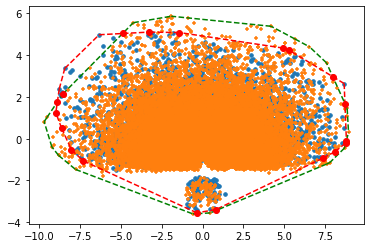

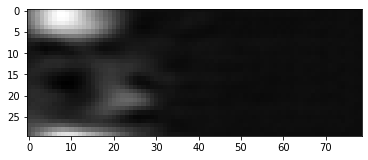

l_D: tf.Tensor(1.3953886, shape=(), dtype=float32)
l_G: tf.Tensor(0.68928385, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00862402], shape=(1,), dtype=float32)
IOU_score: 0.8458453734463357


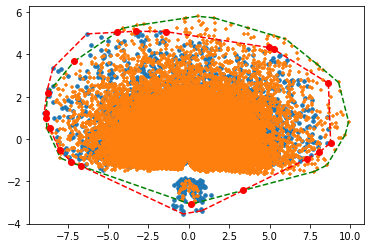

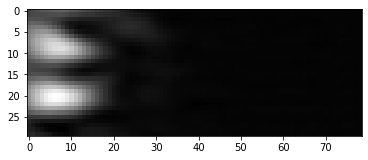

l_D: tf.Tensor(1.4208878, shape=(), dtype=float32)
l_G: tf.Tensor(0.70415556, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.01064931], shape=(1,), dtype=float32)
IOU_score: 0.841482988568418


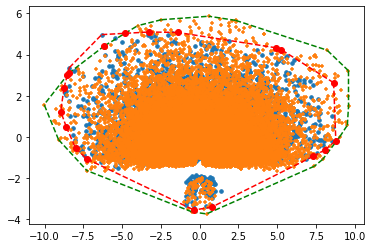

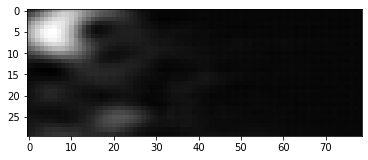

l_D: tf.Tensor(1.3974566, shape=(), dtype=float32)
l_G: tf.Tensor(0.6745275, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03776894], shape=(1,), dtype=float32)
IOU_score: 0.8223212072097951


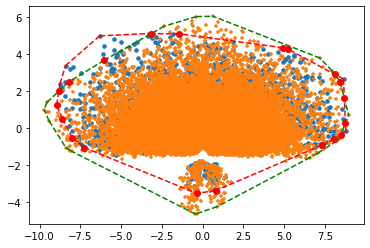

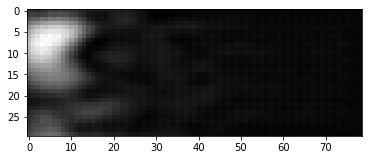

l_D: tf.Tensor(1.4516294, shape=(), dtype=float32)
l_G: tf.Tensor(0.6789213, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03053033], shape=(1,), dtype=float32)
IOU_score: 0.8051398328155669


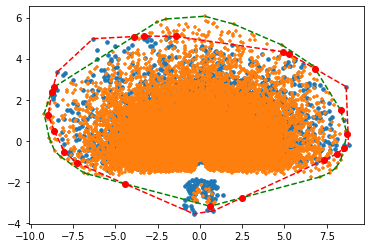

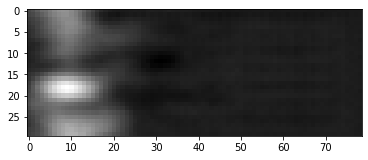

l_D: tf.Tensor(1.3823624, shape=(), dtype=float32)
l_G: tf.Tensor(0.7565816, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.09554891], shape=(1,), dtype=float32)
IOU_score: 0.8517043216253085


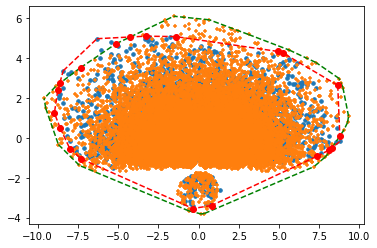

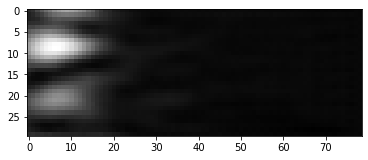

l_D: tf.Tensor(1.3762599, shape=(), dtype=float32)
l_G: tf.Tensor(0.68569154, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.01662706], shape=(1,), dtype=float32)
IOU_score: 0.8575632367913749


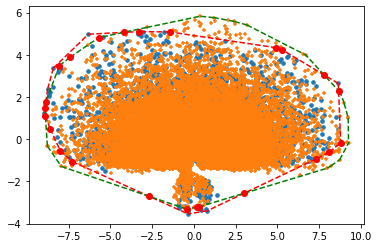

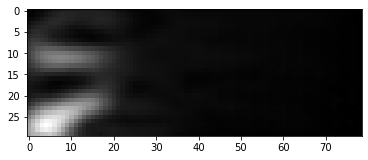

l_D: tf.Tensor(1.4013357, shape=(), dtype=float32)
l_G: tf.Tensor(0.65596163, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.07752068], shape=(1,), dtype=float32)
IOU_score: 0.885747855438528


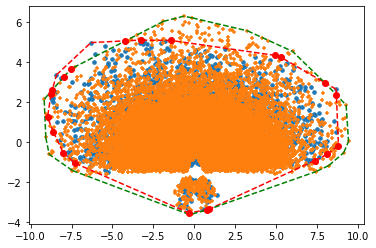

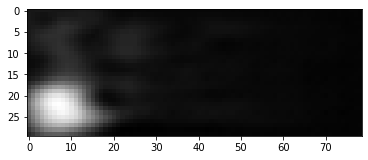

l_D: tf.Tensor(1.3937461, shape=(), dtype=float32)
l_G: tf.Tensor(0.66282856, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.06318315], shape=(1,), dtype=float32)
IOU_score: 0.8498618410979701


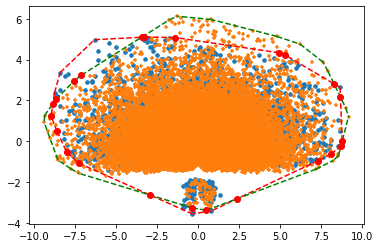

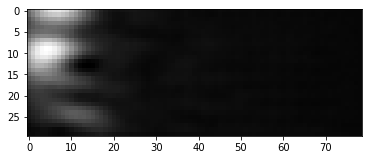

l_D: tf.Tensor(1.4063067, shape=(), dtype=float32)
l_G: tf.Tensor(0.6567122, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.0758898], shape=(1,), dtype=float32)
IOU_score: 0.8423955477864232


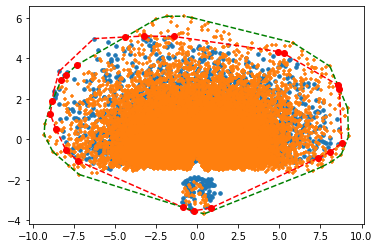

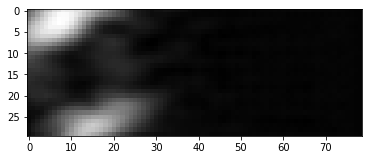

l_D: tf.Tensor(1.3978634, shape=(), dtype=float32)
l_G: tf.Tensor(0.6809478, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02650424], shape=(1,), dtype=float32)
IOU_score: 0.8456528490373707


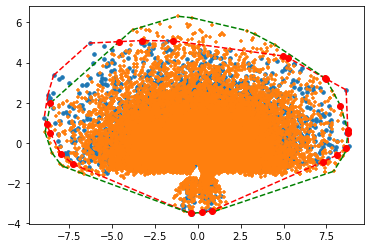

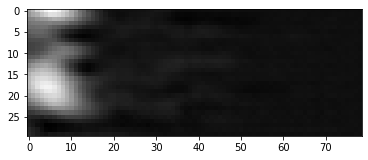

l_D: tf.Tensor(1.3885107, shape=(), dtype=float32)
l_G: tf.Tensor(0.73333514, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.07305154], shape=(1,), dtype=float32)
IOU_score: 0.8490180557416865


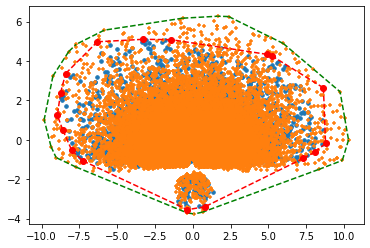

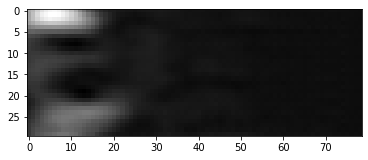

l_D: tf.Tensor(1.3804079, shape=(), dtype=float32)
l_G: tf.Tensor(0.68277687, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.02600291], shape=(1,), dtype=float32)
IOU_score: 0.7682756464898488


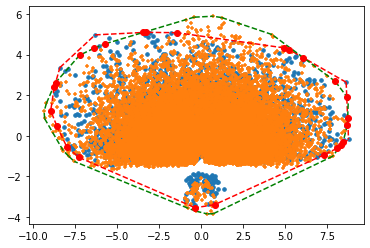

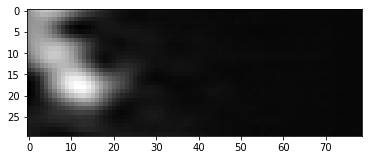

l_D: tf.Tensor(1.4035935, shape=(), dtype=float32)
l_G: tf.Tensor(0.67398214, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.03997582], shape=(1,), dtype=float32)
IOU_score: 0.8867610581560903


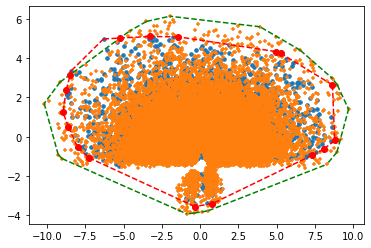

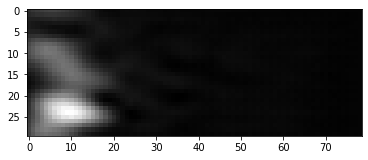

l_D: tf.Tensor(1.3632541, shape=(), dtype=float32)
l_G: tf.Tensor(0.7223459, shape=(), dtype=float32)
Z_avr: tf.Tensor([-0.05300504], shape=(1,), dtype=float32)
IOU_score: 0.7936443720901984


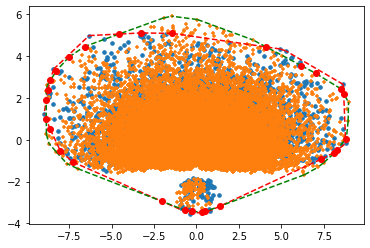

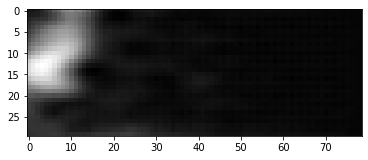

l_D: tf.Tensor(1.3614597, shape=(), dtype=float32)
l_G: tf.Tensor(0.6563653, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.07645568], shape=(1,), dtype=float32)
IOU_score: 0.9195246402591568


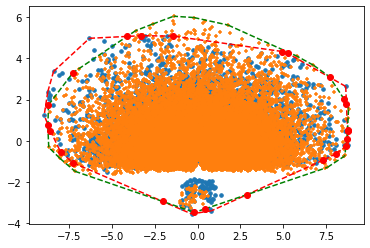

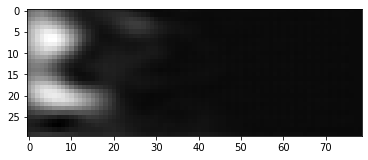

l_D: tf.Tensor(1.361984, shape=(), dtype=float32)
l_G: tf.Tensor(0.69171727, shape=(), dtype=float32)
Z_avr: tf.Tensor([0.00741773], shape=(1,), dtype=float32)
IOU_score: 0.8816173589946348


In [22]:
for epoch in tf.range(20000):
    for i in tf.range(total_batch):
        batch_input = final_data_limit[i*batch_size:(i+1)*batch_size]
        batch_input = np.reshape(batch_input,[-1,30,79,1])

        l_D,l_G,G_v,Z_v,R_v=train_step(batch_input)
        
        
# 생성된 이미지
    if epoch%70==0:
        G = Generator(get_noise(1,100))
        
        pc1=pca_data(final_data_limit)
        pc2=pca_data(np.reshape(Generator(get_noise(2000,100)),(-1,30,79)))
        IOU = IOU_score(pc1,pc2)
        if IOU>0.88:
            for np_load in range(number_of_load):
                G = Generator(get_noise(5,100))
                file_name = './gan_normal_file4/saved_'+str(np_load+np_load_count)
                np.save(file_name,G)
                stop_per = np_load+np_load_count
            np_load_count += number_of_load

        plt.imshow(np.reshape(G[0],(30,79)),interpolation="nearest",cmap='gray')
        plt.pause(0.001)
        print("l_D:",str(l_D))
        print("l_G:",str(l_G))
        print("Z_avr:",str(sum(Z_v)/Z_v.shape[0]))
        print("IOU_score:",str(IOU))
        plt.show()
        
    if stop_per >= want_data-1:
        break